In [1]:
import matplotlib.pyplot as plt
import random
import math

from transformers import CLIPTokenizer, CLIPTextModel
from torch import nn

/home/eranario/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AbstractEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    def encode(self, *args, **kwargs):
        raise NotImplementedError

class FrozenCLIPEmbedder(AbstractEncoder):
    """Uses the CLIP transformer encoder for text (from Hugging Face)"""
    LAYERS = [
        "last",
        "pooled",
        "hidden"
    ]
    
    def __init__(self, version="openai/clip-vit-large-patch14", device="cuda", max_length=77,
                 freeze=True, layer="last", layer_idx=None):  
        super().__init__()
        assert layer in self.LAYERS
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.transformer = CLIPTextModel.from_pretrained(version)
        self.device = device
        self.max_length = max_length
        if freeze:
            self.freeze()
        self.layer = layer
        self.layer_idx = layer_idx
        if layer == "hidden":
            assert layer_idx is not None
            assert 0 <= abs(layer_idx) <= 12
        
        # Move the model to the specified device
        self.transformer = self.transformer.to(self.device)

    def freeze(self):
        self.transformer = self.transformer.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        # Tokenize the input text
        batch_encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        
        # Move tokens to the specified device
        tokens = batch_encoding["input_ids"].to(self.device)

        # Forward pass through the transformer
        outputs = self.transformer(input_ids=tokens, output_hidden_states=self.layer == "hidden")
        
        # Choose which output layer to use
        if self.layer == "last":
            z = outputs.last_hidden_state
        elif self.layer == "pooled":
            z = outputs.pooler_output[:, None, :]
        else:
            z = outputs.hidden_states[self.layer_idx]
        
        # Convert token IDs back to readable tokens
        token_strings = [self.tokenizer.convert_ids_to_tokens(ids.cpu()) for ids in batch_encoding['input_ids']]
        
        return z, token_strings

    def visualize_tokens_with_matplotlib(self, text, tokens_per_row=20, token_font_size=12, position_font_size=10,
                                         word_spacing=1.0, row_spacing=0.5):
        """
        Visualize tokens with customizable font sizes and spacing.

        Args:
        - tokens_per_row (int): Maximum number of tokens per row.
        - token_font_size (int): Font size for the tokens.
        - position_font_size (int): Font size for the position numbers.
        - word_spacing (float): Horizontal spacing between words.
        - row_spacing (float): Vertical spacing between rows.
        """
        _, token_strings = self.forward(text)
        colors = ["#FFDDC1", "#FEC8D8", "#D4A5A5", "#C4E3F9", "#FFAAA5", "#FFD3B6", "#A8E6CF", "#DCEDC2"]

        for tokens in token_strings:
            color_map = {}
            token_positions = []
            visible_tokens = []
            endoftext_start = None

            # Assign a color and handle `endoftext` tokens
            for idx, token in enumerate(tokens):
                if token == "[PAD]" or (token == "<|endoftext|>" and endoftext_start is None):
                    endoftext_start = idx
                    continue  # Skip padding and start/end of `endoftext`

                # If the token isn't `endoftext`, store it
                if token != "<|endoftext|>":
                    token_positions.append(idx)
                    visible_tokens.append(token)
                    if token not in color_map:
                        color_map[token] = random.choice(colors)

            # Split tokens into rows
            num_rows = math.ceil(len(visible_tokens) / tokens_per_row)

            # Adjust the figure size dynamically based on the number of rows and tokens
            fig, ax = plt.subplots(figsize=(min(tokens_per_row * word_spacing, len(visible_tokens) * word_spacing), num_rows * row_spacing * 2))  # Dynamic figure size

            ax.set_axis_off()

            # Plot visible tokens and positions in rows
            for row in range(num_rows):
                start_idx = row * tokens_per_row
                end_idx = min((row + 1) * tokens_per_row, len(visible_tokens))
                row_tokens = visible_tokens[start_idx:end_idx]
                row_positions = token_positions[start_idx:end_idx]

                for i, (token, pos) in enumerate(zip(row_tokens, row_positions)):
                    x_pos = i * word_spacing + 0.5  # Horizontal position with adjustable word spacing
                    y_pos = -row * row_spacing  # Vertical position with adjustable row spacing

                    ax.text(x_pos, y_pos + row_spacing / 2, token, fontsize=token_font_size, backgroundcolor=color_map[token], ha='center', va='center')
                    ax.text(x_pos, y_pos + row_spacing, str(pos), fontsize=position_font_size, color='gray', ha='center')

            # Handle `endoftext` token (only show start and end positions)
            if endoftext_start is not None:
                endoftext_end = len(tokens) - 1
                ax.text(0.5 + (endoftext_start % tokens_per_row) * word_spacing, -endoftext_start // tokens_per_row * row_spacing + row_spacing / 2,
                        "<|endoftext|>", fontsize=token_font_size, color='red', ha='center', va='center')
                ax.text(0.5 + (endoftext_start % tokens_per_row) * word_spacing, -endoftext_start // tokens_per_row * row_spacing + row_spacing,
                        f"{endoftext_start}-{endoftext_end}", fontsize=position_font_size, color='gray', ha='center')

            plt.tight_layout()
            plt.show()

/tmp/ipykernel_10692/3996969154.py:128: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


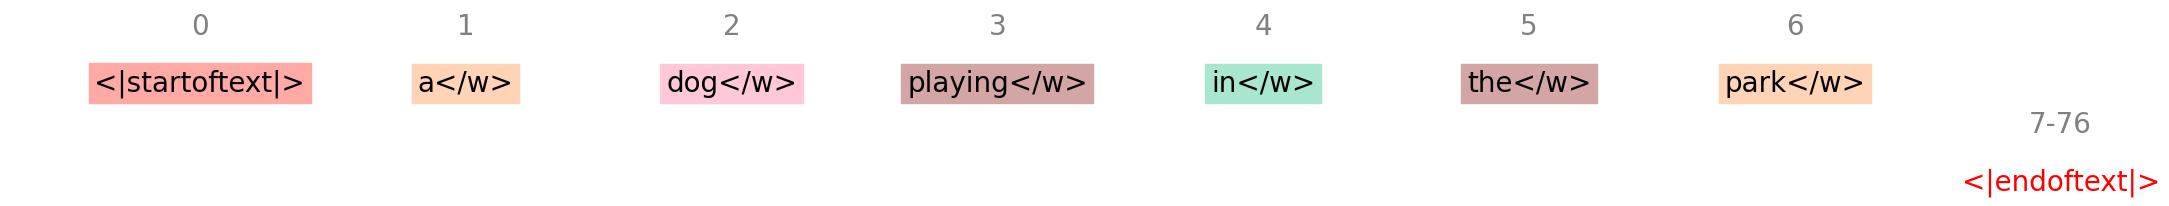

In [3]:
# Example usage:
embedder = FrozenCLIPEmbedder(device="cuda")

# Example input text
input_text = ["A dog playing in the park"]

# Visualize the tokens with customizable parameters
embedder.visualize_tokens_with_matplotlib(input_text, tokens_per_row=10, token_font_size=20, position_font_size=20,
                                          word_spacing=0.7, row_spacing=0.8)

/tmp/ipykernel_10692/3996969154.py:128: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


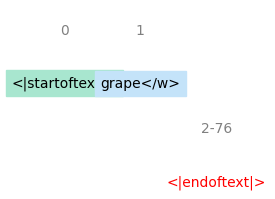

In [4]:
# Example input text
input_text = ["grape"]

# Visualize the tokens with customizable parameters
embedder.visualize_tokens_with_matplotlib(input_text, tokens_per_row=10, token_font_size=10, position_font_size=10,
                                          word_spacing=0.7, row_spacing=0.8)

/tmp/ipykernel_10692/3996969154.py:128: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


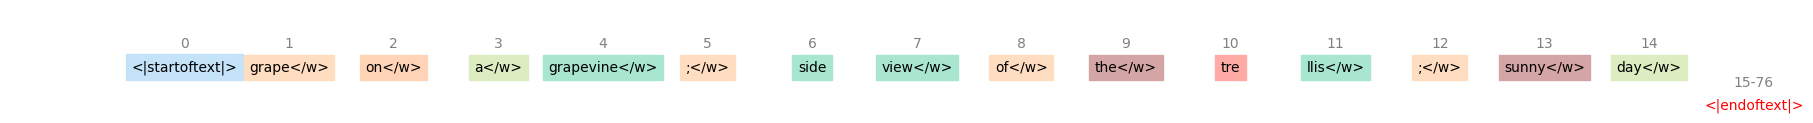

In [13]:
input_text = ["grape on a grapevine; sideview of the trellis; sunny day"]

# Visualize the tokens with customizable parameters
embedder.visualize_tokens_with_matplotlib(input_text, tokens_per_row=20, token_font_size=10, position_font_size=10,
                                          word_spacing=0.3, row_spacing=0.5)